In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import csv
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys, os
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from data_manager import *
from metadata import *

Setting environment for Precision WorkStation


No vtk


In [3]:
from annotation_utilities import *
from registration_utilities import *
from conversion import *

In [26]:
brain_annotation_file_map = \
{
'M920': os.path.join(ROOT_DIR, 'LGN3Datlas', 'm920', 'm920LGN.json'),
'M919': os.path.join(ROOT_DIR, 'LGN3Datlas', 'm919', 'm919LGN.json'),
'M1144': os.path.join(ROOT_DIR, 'LGN3Datlas', 'm1144', 'm1144LGN.json'),
}

In [5]:
XY_PIXEL_SIZE_UM = 0.46

In [6]:
import json

In [7]:
tb_resol = 'down64'

In [8]:
stack = 'M919'

In [14]:
transforms_to_anchor_um = DataManager.load_transforms_v2(stack=stack, in_image_resolution=tb_resol, 
                               out_image_resolution='1.0um',
                                                          anchor_fn=DataManager.load_anchor_filename(stack))

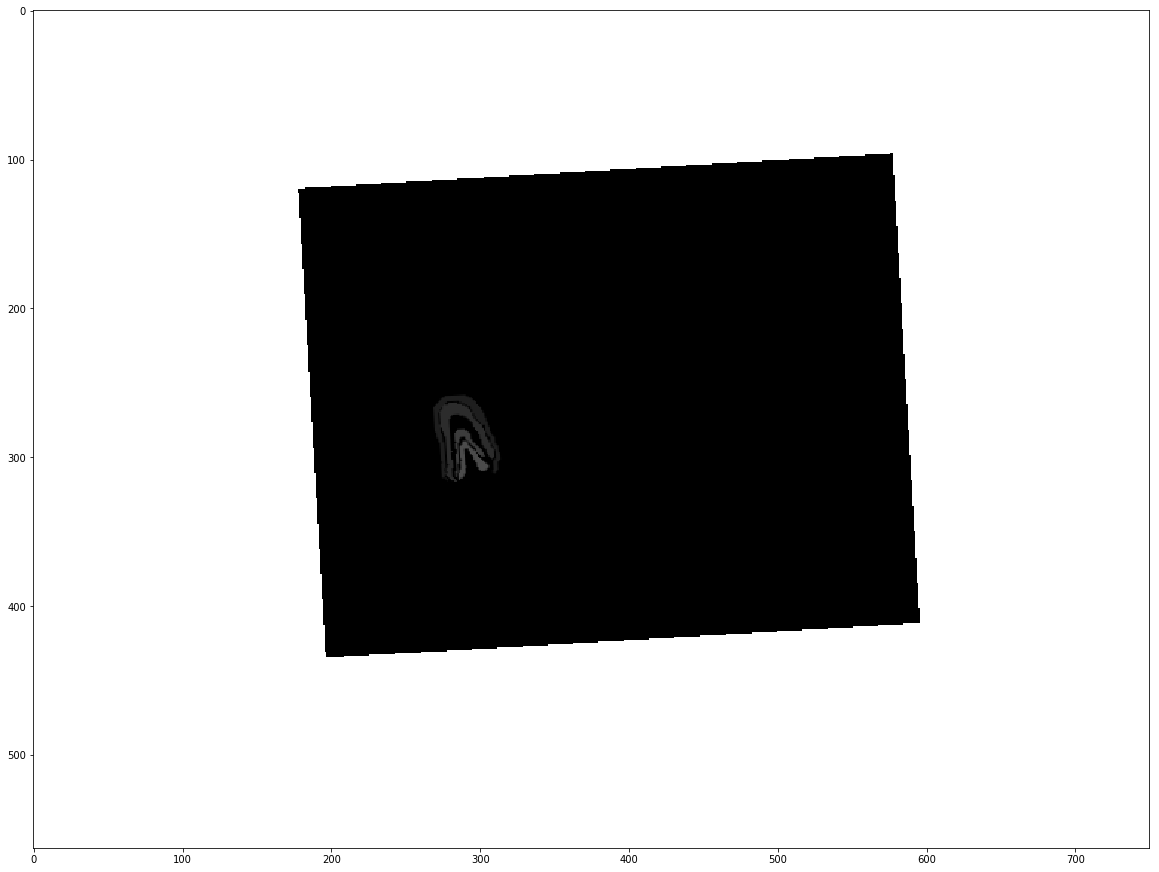

In [41]:
plt.figure(figsize=(20,20));
plt.imshow(img, plt.cm.gray);

In [30]:
data['APul']

[{u'z': 0},
 {u'z': 80},
 {u'z': 160},
 {u'z': 240},
 {u'z': 400},
 {u'z': 480},
 {u'z': 560},
 {u'z': 640},
 {u'z': 720},
 {u'z': 800},
 {u'z': 880},
 {u'z': 960},
 {u'xy': [[8676, 8150],
   [9021, 8196],
   [9385, 8169],
   [9668, 8296],
   [9997, 8621],
   [10032, 9016],
   [9964, 9257],
   [9881, 9353],
   [9580, 9325],
   [9261, 9233],
   [9050, 9118],
   [8855, 8848],
   [8722, 8723],
   [8614, 8663],
   [8669, 8328]],
  u'z': 1040},
 {u'xy': [[8595, 8323],
   [8979, 8224],
   [9471, 8149],
   [9830, 8149],
   [10014, 8167],
   [10167, 8330],
   [10284, 8458],
   [10324, 8586],
   [10325, 8749],
   [10206, 8878],
   [10000, 8973],
   [9774, 9001],
   [9485, 8977],
   [9237, 8959],
   [8906, 8955],
   [8686, 8930],
   [8585, 8929],
   [8638, 8768],
   [8615, 8610],
   [8596, 8447]],
  u'z': 1120},
 {u'xy': [[9240, 7667],
   [9380, 7767],
   [9497, 7850],
   [9705, 8014],
   [9856, 8123],
   [10005, 8215],
   [10241, 8357],
   [10396, 8500],
   [10479, 8590],
   [10503, 8713],
   [

In [31]:
1040/60

17

In [ ]:
# for stack in brain_annotation_file_map.keys():
# for stack in ['m920LGN', 'm919LGN', 'm1144LGN']:
for stack in ['M919']:
    
    print stack

    input_file = brain_annotation_file_map[stack]
    
    with open(input_file, 'r') as f:
        data = json.load(f)

    contours_um = defaultdict(list)
    for name, cnts in data.iteritems():
        for cnt in cnts:
            if 'xy' in cnt:
                
                cnt['z'] / 60.
                
                contours_um[name].append(np.column_stack([np.array(cnt['xy']) * XY_PIXEL_SIZE_UM, 
                                                       cnt['z']*np.ones((len(cnt['xy']),))]))
    
                
    
                transform_points(pts=contours_um, transform=transforms_to_anchor_um[])
    
    contours_um.default_factory = None
    

    contour_colors = dict(zip(contours_um.keys(), np.array(random_colors(len(contours_um)))/255.))
    
    #############################
    
    plt.figure(figsize=(10, 10));
    for name, cnts in contours_um.iteritems():    
        for cnt in cnts:
            plt.plot(cnt[:, 0], cnt[:, 1], c=contour_colors[name]);

    plt.xlabel('x');
    plt.ylabel('y');
    plt.axis('equal');
    # plt.legend();

    ##############################

    plt.figure(figsize=(10, 10));
    for name, cnts in contours_um.iteritems():    
        for cnt in cnts:
            plt.plot(cnt[:, 2], cnt[:, 1], c=contour_colors[name]);

    plt.xlabel('x');
    plt.ylabel('y');
    plt.axis('equal');
    # plt.legend();

    out_resolution = '10.0um'
    out_resolution_um = convert_resolution_string_to_um(resolution=out_resolution)

    contours_orientationCorrected = {convert_to_left_name(name_u): [cnt[:, [2,1,0]]*[1,-1,1]
                                     for cnt in cnts3d] 
                           for name_u, cnts3d in contours_um.iteritems()}
#     contours_orientationCorrected = {convert_to_left_name(name_u): [cnt
#                                      for cnt in cnts3d] 
#                            for name_u, cnts3d in contours.iteritems()}

    contours_atlasResol = {name: [cnt / out_resolution_um
                                    for cnt in cnts3d if len(cnt) > 3] 
                           for name, cnts3d in contours_orientationCorrected.iteritems()}

    
    # Convert contours to volumes

    valid_level = .5

#     surround_distance_um = 200.
#     surround_distance_voxel = surround_distance_um / out_resolution_um
#     print "surround size (in voxels):", surround_distance_voxel

    # Reconstruct brain.

    reconstructed_brain = {}

    for name, cnts3d in contours_atlasResol.iteritems():
        reconstructed_brain[name] = interpolate_contours_to_volume(interpolation_direction='x',
                                                        contours_xyz=cnts3d, 
                                                        len_interval=20.,
                                                            return_origin_instead_of_bbox=True)

#         surround_name = convert_to_surround_name(name, margin='%dum' % surround_distance_um)

#         reconstructed_brain[surround_name] = \
#         get_surround_volume_v2(vol=reconstructed_brain[name][0], origin=reconstructed_brain[name][1], 
#                                wall_level=valid_level, distance=surround_distance_voxel, 
#                                prob=True,
#                                return_origin_instead_of_bbox=True)
    
    for s, v in reconstructed_brain.iteritems():
        vol_fp = DataManager.get_original_volume_filepath_v2(stack_spec=dict(name=stack, 
                                                                         vol_type='annotationAsScore',
                                                                resolution=out_resolution),
                                            
                                            structure=s)
        save_data(v[0], vol_fp, upload_s3=False)
        
        origin_fp = DataManager.get_original_volume_origin_filepath_v3(stack_spec=dict(name=stack, 
                                                                         vol_type='annotationAsScore',
                                                                        resolution=out_resolution),
                                            structure=s)
        save_data(v[1], origin_fp, upload_s3=False)

In [8]:
reconstructed_brain.keys()

[u'ExMC_L',
 u'MPul_L',
 u'LPul_L',
 u'IPul_L',
 u'InMC_L',
 u'ExPC_L',
 u'IPulCM_L',
 u'IPulM_L',
 u'InPC_L',
 u'IPulP_L',
 u'DLG_L',
 u'IPulCL_L',
 u'APul_L']